In [1]:
!pip install transformers

In [2]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

Found existing installation: matplotlib 3.7.3
Uninstalling matplotlib-3.7.3:
  Successfully uninstalled matplotlib-3.7.3
  Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)


In [3]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-15 23:26:03.433382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 23:26:03.433445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 23:26:03.433475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 23:26:03.441403: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Define the connection between Input data and Label

In [4]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [5]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [6]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = "/mnt/train_data_small.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/train_data_small.tfrecord
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


2024-01-15 23:26:16.031628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 23:26:16.038683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 23:26:16.038730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 23:26:16.041495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-15 23:26:16.041597: I tensorflow/compile

In [7]:
print(train_dataset)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = "/mnt/validation_data_small.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/validation_data_small.tfrecord


In [9]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [10]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [ ]:
# Adding the layer for fine tuning on BERT

In [11]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Set up the custom classifier model

In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 input_mask (InputLayer)     [(None, 64)]                 0         []                            
                                                                                                  
 distilbert (TFDistilBertMa  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 inLayer)                    den_state=(None, 64, 768),   0          'input_mask[0][0]']          
                              hidden_states=None, atten                                           
                             tions=None)                                                      

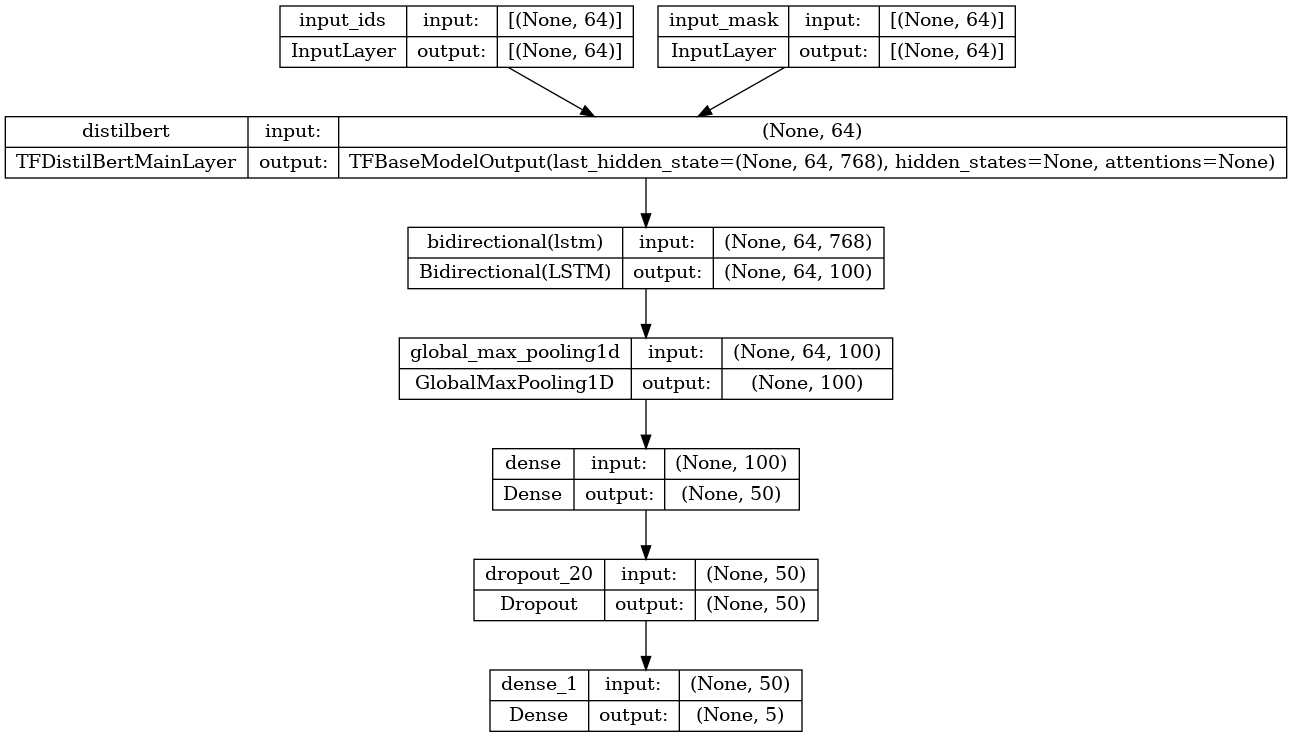

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [14]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [15]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-15 23:26:55.485483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x565313d8f5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 23:26:55.485531: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P1000, Compute Capability 6.1
2024-01-15 23:26:55.491662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-15 23:26:55.508140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-01-15 23:26:55.574193: I ./tensorflow/compiler/jit/devic

1/1 [==============================] - 16s 16s/step - loss: 1.6040 - accuracy: 0.1250 - val_loss: 1.6759 - val_accuracy: 0.2500


In [16]:
epochs = 256
steps_per_epoch = 32
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-3
epsilon = 1e-08
max_seq_length = 64

In [17]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/256
32/32 [==============================] - 51s 2s/step - loss: 1.6884 - accuracy: 0.1992 - val_loss: 1.6192 - val_accuracy: 0.1953
Epoch 2/256
32/32 [==============================] - 51s 2s/step - loss: 1.6090 - accuracy: 0.2734 - val_loss: 1.6087 - val_accuracy: 0.2305
Epoch 3/256
32/32 [==============================] - 50s 2s/step - loss: 1.6079 - accuracy: 0.2266 - val_loss: 1.6010 - val_accuracy: 0.2305
Epoch 4/256
32/32 [==============================] - 51s 2s/step - loss: 1.6243 - accuracy: 0.2148 - val_loss: 1.5952 - val_accuracy: 0.2305
Epoch 5/256
32/32 [==============================] - 51s 2s/step - loss: 1.6022 - accuracy: 0.2695 - val_loss: 1.5910 - val_accuracy: 0.2422
Epoch 6/256
32/32 [==============================] - 51s 2s/step - loss: 1.6067 - accuracy: 0.2617 - val_loss: 1.5878 - val_accuracy: 0.2500
Epoch 7/256
32/32 [==============================] - 50s 2s/step - loss: 1.6128 - accuracy: 0.2500 - val_loss: 1.5826 - val_accuracy: 0.2500
Epoch 8/256
3

Epoch 59/256
32/32 [==============================] - 51s 2s/step - loss: 1.3910 - accuracy: 0.4102 - val_loss: 1.3209 - val_accuracy: 0.3906
Epoch 60/256
32/32 [==============================] - 51s 2s/step - loss: 1.3462 - accuracy: 0.4062 - val_loss: 1.3216 - val_accuracy: 0.3984
Epoch 61/256
32/32 [==============================] - 51s 2s/step - loss: 1.3984 - accuracy: 0.3789 - val_loss: 1.3155 - val_accuracy: 0.3906
Epoch 62/256
32/32 [==============================] - 52s 2s/step - loss: 1.3440 - accuracy: 0.4258 - val_loss: 1.3140 - val_accuracy: 0.4180
Epoch 63/256
32/32 [==============================] - 51s 2s/step - loss: 1.3572 - accuracy: 0.3906 - val_loss: 1.3064 - val_accuracy: 0.3945
Epoch 64/256
32/32 [==============================] - 54s 2s/step - loss: 1.3984 - accuracy: 0.3828 - val_loss: 1.3038 - val_accuracy: 0.3984
Epoch 65/256
32/32 [==============================] - 56s 2s/step - loss: 1.3759 - accuracy: 0.3867 - val_loss: 1.3035 - val_accuracy: 0.3945
Epoch 

32/32 [==============================] - 51s 2s/step - loss: 1.2522 - accuracy: 0.4336 - val_loss: 1.2217 - val_accuracy: 0.4531
Epoch 117/256
32/32 [==============================] - 51s 2s/step - loss: 1.4042 - accuracy: 0.3984 - val_loss: 1.2221 - val_accuracy: 0.4727
Epoch 118/256
32/32 [==============================] - 53s 2s/step - loss: 1.2459 - accuracy: 0.4648 - val_loss: 1.2210 - val_accuracy: 0.4531
Epoch 119/256
32/32 [==============================] - 51s 2s/step - loss: 1.2686 - accuracy: 0.4297 - val_loss: 1.2193 - val_accuracy: 0.4609
Epoch 120/256
32/32 [==============================] - 51s 2s/step - loss: 1.3069 - accuracy: 0.4453 - val_loss: 1.2206 - val_accuracy: 0.4570
Epoch 121/256
32/32 [==============================] - 51s 2s/step - loss: 1.3008 - accuracy: 0.4258 - val_loss: 1.2188 - val_accuracy: 0.4375
Epoch 122/256
32/32 [==============================] - 51s 2s/step - loss: 1.3277 - accuracy: 0.4375 - val_loss: 1.2192 - val_accuracy: 0.4141
Epoch 123/256

32/32 [==============================] - 53s 2s/step - loss: 1.2917 - accuracy: 0.4414 - val_loss: 1.1970 - val_accuracy: 0.4883
Epoch 174/256
32/32 [==============================] - 52s 2s/step - loss: 1.3185 - accuracy: 0.4219 - val_loss: 1.1973 - val_accuracy: 0.5117
Epoch 175/256
32/32 [==============================] - 53s 2s/step - loss: 1.3467 - accuracy: 0.4062 - val_loss: 1.2027 - val_accuracy: 0.5039
Epoch 176/256
32/32 [==============================] - 51s 2s/step - loss: 1.2963 - accuracy: 0.4688 - val_loss: 1.1960 - val_accuracy: 0.5039
Epoch 177/256
32/32 [==============================] - 52s 2s/step - loss: 1.2626 - accuracy: 0.4336 - val_loss: 1.1948 - val_accuracy: 0.4805
Epoch 178/256
32/32 [==============================] - 52s 2s/step - loss: 1.2931 - accuracy: 0.4375 - val_loss: 1.1941 - val_accuracy: 0.5039
Epoch 179/256
32/32 [==============================] - 52s 2s/step - loss: 1.2406 - accuracy: 0.4766 - val_loss: 1.1937 - val_accuracy: 0.4805
Epoch 180/256

32/32 [==============================] - 56s 2s/step - loss: 1.3063 - accuracy: 0.4180 - val_loss: 1.1699 - val_accuracy: 0.4883
Epoch 231/256
32/32 [==============================] - 56s 2s/step - loss: 1.2585 - accuracy: 0.4375 - val_loss: 1.1735 - val_accuracy: 0.4961
Epoch 232/256
32/32 [==============================] - 56s 2s/step - loss: 1.2706 - accuracy: 0.4180 - val_loss: 1.1754 - val_accuracy: 0.5039
Epoch 233/256
32/32 [==============================] - 56s 2s/step - loss: 1.3189 - accuracy: 0.4062 - val_loss: 1.1809 - val_accuracy: 0.4922
Epoch 234/256
32/32 [==============================] - 56s 2s/step - loss: 1.2161 - accuracy: 0.4844 - val_loss: 1.1715 - val_accuracy: 0.4922
Epoch 235/256
32/32 [==============================] - 56s 2s/step - loss: 1.2703 - accuracy: 0.4375 - val_loss: 1.1716 - val_accuracy: 0.4922
Epoch 236/256
32/32 [==============================] - 56s 2s/step - loss: 1.3127 - accuracy: 0.3789 - val_loss: 1.1755 - val_accuracy: 0.4766
Epoch 237/256

In [18]:
print(history.history)

{'loss': [1.6883543729782104, 1.6090203523635864, 1.6079075336456299, 1.624314308166504, 1.6022192239761353, 1.60673189163208, 1.612849473953247, 1.5966720581054688, 1.5736130475997925, 1.5875170230865479, 1.573608160018921, 1.5939667224884033, 1.5844537019729614, 1.5726693868637085, 1.564321756362915, 1.5744268894195557, 1.579792857170105, 1.5631985664367676, 1.548126220703125, 1.5259095430374146, 1.538347601890564, 1.5422197580337524, 1.5271753072738647, 1.537987232208252, 1.4969943761825562, 1.530104637145996, 1.494370937347412, 1.480918526649475, 1.457119345664978, 1.475178837776184, 1.4813663959503174, 1.483278512954712, 1.4405059814453125, 1.500794529914856, 1.4630223512649536, 1.4775869846343994, 1.4870367050170898, 1.4256116151809692, 1.470260739326477, 1.4430228471755981, 1.4126503467559814, 1.4649475812911987, 1.4552243947982788, 1.3893605470657349, 1.412950873374939, 1.429192304611206, 1.405860424041748, 1.4099533557891846, 1.4640446901321411, 1.425313115119934, 1.3306068181

In [19]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [20]:
# Adhoc predict

In [21]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.8051944375038147}

In [22]:
predict("This is cool.")

1/1 [==============================] - 0s 159ms/step


{'label': 5, 'socre': 0.43080174922943115}

In [23]:
predict("I don't like this.")

1/1 [==============================] - 0s 172ms/step


{'label': 1, 'socre': 0.45273786783218384}

In [24]:
predict("I might buy it again.")

1/1 [==============================] - 0s 122ms/step


{'label': 3, 'socre': 0.3263733983039856}

In [25]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 120ms/step


{'label': 3, 'socre': 0.394609659910202}

In [26]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

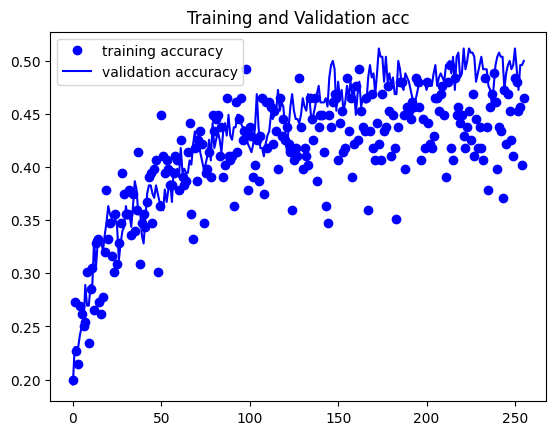

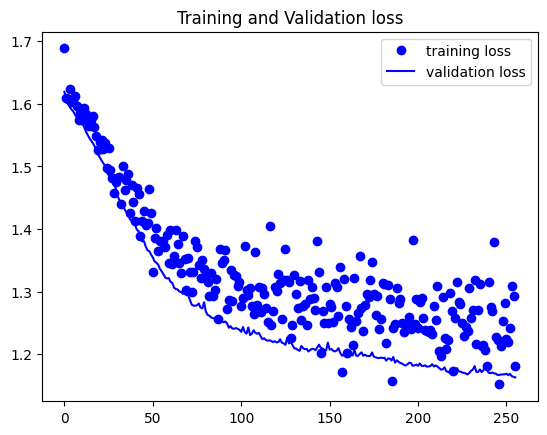

In [27]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [28]:
model.save('/mnt/tensorflow_small/',save_format='tf')

INFO:tensorflow:Assets written to: /mnt/tensorflow_small/assets


INFO:tensorflow:Assets written to: /mnt/tensorflow_small/assets


In [29]:
!ls /mnt/tensorflow_small

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>